<a href="https://colab.research.google.com/github/karencfisher/Hotel-Cancellations/blob/master/notebooks/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installations of dependencies

!pip install category_encoders==2.*
!pip install eli5

!wget https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py

!pip install pdpbox
!pip install shap


     |████████████████████████████████| 81kB 2.2MB/s 
     |████████████████████████████████| 112kB 2.8MB/s 
--2020-06-23 10:30:46--  https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12186 (12K) [text/plain]
Saving to: ‘tools.py’

tools.py            100%[===================>]  11.90K  --.-KB/s    in 0s      

2020-06-23 10:30:46 (97.4 MB/s) - ‘tools.py’ saved [12186/12186]

     |████████████████████████████████| 57.7MB 61kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=4cb1ae72fd6c33bfb935347546dded49ede41fdb5cfa0779caf654119cd61729
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3

In [2]:
# Import libraries (line up most toys we might want)

import tools
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import category_encoders as ce

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder,  StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.utils import compute_class_weight
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of th

###Load the data set and make train, validate, and test sets

In [3]:
# Load dataset

url = 'https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/hotel_bookings.csv'
df = pd.read_csv(url)

# Correct some target values -- should be 'no-show' or 'cancellation' when checkout and
# arrival dates same indicating no stay
df = tools.fixTarget(df)

# Convert no shows to cancellations
df['reservation_status'] = df['reservation_status'].replace('No-Show', 'Canceled')

# Prepare training, validation, and test sets
X = df.drop('reservation_status', axis=1)
y = df['reservation_status']

# I've found improvement in model performance to encode the classes as true/false (1/0)
# Cancellations should be True or 1, as that is our positive case.
y = y == 'Canceled'

# Train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42,
                                                    stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.3,
                                                  random_state=42, stratify=y_train)

### Mapping categorical features properly

In [4]:
cat_map = [{'col': 'meal', 'mapping': {'SC': 0, 'BB': 1, 'HB': 2, 'FB': 3}},
           {'col': 'hotel', 'mapping': {'City Hotel': 1, 'Resort Hotel': 2}},
           {'col': 'deposit_type', 'mapping': {'No Deposit': 0, 'Refundable': 1,
                                               'Non Refund': 2}},
           {'col': 'market_segment', 'mapping': {'Direct': 1, 'Corporate': 2,
                                                'Online TA': 3,
                                                'Complementary': 0,
                                                'Aviation': 4,
                                                'Offline TA/TO': 5,
                                                'Undefined': 1}},
           {'col': 'customer_type', 'mapping': {'Transient': 1,
                                                'Transient-Party': 2,
                                                'Contract': 3, 'Group': 4}}]

### Correlations between predictors and the output

Using SelectKBest to get chi2 scores. Does this help understand the model?

In [5]:
# Some added EDA, evaluating chi^2 scores of correlation between predictors and the
# output classes
pipe = make_pipeline(tools.wrangleData(max_cardinality=50),
                          ce.OrdinalEncoder(),
                          SimpleImputer(),
                          SelectKBest(score_func=chi2, k='all'))
pipe.fit(X_train, y_train)

# Make a table of the results and plot them
scores = pd.Series(pipe.named_steps['selectkbest'].scores_, 
                   pipe.named_steps['wrangledata'].columns_)

scores.sort_values(ascending=False)

lead_time                      504564.783473
days_in_waiting_list            19539.001590
previous_cancellations           5663.770897
total_of_special_requests        3606.199705
room_type_changed                2791.917582
booking_changes                  2333.623388
required_car_parking_spaces      2157.184783
deposit_type                     1222.317541
market_segment                    292.399885
is_repeated_guest                 208.829921
customer_type                     201.617237
hotel                             125.503267
nights_stay                        29.704672
adults                             25.129085
arrival_date_week_number           19.036394
meal                                3.657148
adr                                 0.427247
dtype: float64

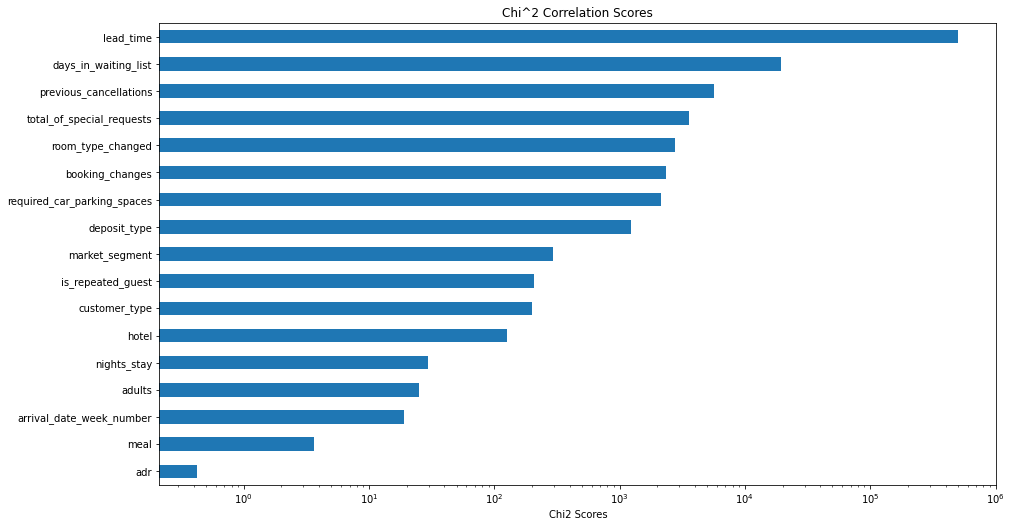

In [6]:
plt.figure(figsize=(15, len(pipe.named_steps['wrangledata'].columns_) / 2))
scores.sort_values().plot.barh()
plt.title('Chi^2 Correlation Scores')
plt.xlabel('Chi2 Scores')

# Use logarithmic scale otherwise some correlations are too small to plot
plt.xscale('log')
plt.savefig('chi2.jpg')
plt.show()


###Get a baseline score

Using the scikit learn 'DummyClassifier'. 

In [7]:
baseline = make_pipeline(tools.wrangleData(max_cardinality=50),
                         ce.OrdinalEncoder(mapping=cat_map),
                         SimpleImputer(),
                         DummyClassifier())

tools.tryModel(baseline, X_train, y_train, X_val, y_val)



Train score = 53.0931095194954 %
Validate score = 52.77999361837907 %




'Confusion Matrix'

,False,True
False,9704,5933
True,5827,3608


'Metrics'

,precision,recall,f1-score
False,0.624815,0.620579,0.62269
True,0.378157,0.382406,0.38027


### Distribution of classes

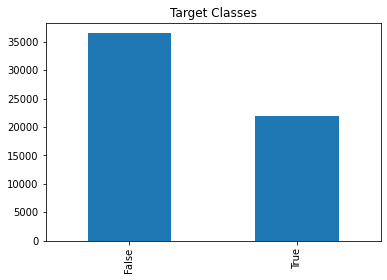

In [8]:
y_train.value_counts().plot.bar()
plt.title('Target Classes')
plt.savefig('target.jpg')
plt.show()

### Logistic Regression model

Will try with the target as it is, with synthetic oversampling the minority class, and randomly subsample the majority class. In each case we will have accuracy score, confusion matrix, recall/precision scores on both classes. Comparison of the distribution of predicted and actual values, and ROC plots.

In all cases, resampling is of course *only* applied to the training set. Doing so seems to better sensitize the model to the minority class, reducing bias for the majority class, in my experience, with little change in the overall accuracy scores (+/- approximately 1%).

####Baseline logistic regression

In [9]:
# Baseline logistic regression model
lr_pipeline = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                            ce.OrdinalEncoder(mapping=cat_map),
                            SimpleImputer(),
                            StandardScaler(),
                            LogisticRegression(n_jobs=-1,
                                               solver='lbfgs'))

tools.tryModel(lr_pipeline, X_train, y_train, X_val, y_val)



Train score = 78.2584913078409 %
Validate score = 79.03637523931079 %




'Confusion Matrix'

,False,True
False,14713,924
True,4332,5103


'Metrics'

,precision,recall,f1-score
False,0.772539,0.940909,0.848452
True,0.846690,0.540859,0.660070


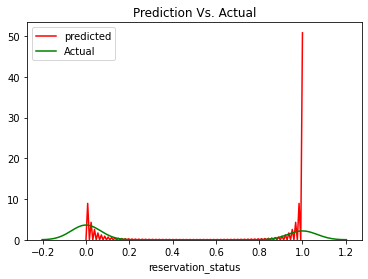

In [10]:
# Compared distribution of predicted and actual values
y_hat = lr_pipeline.predict(X_val)
sns.distplot(y_hat, hist=False, color='red', label='predicted')
sns.distplot(y_val, hist=False, color='green', label='Actual')
plt.title('Prediction Vs. Actual')
plt.legend();

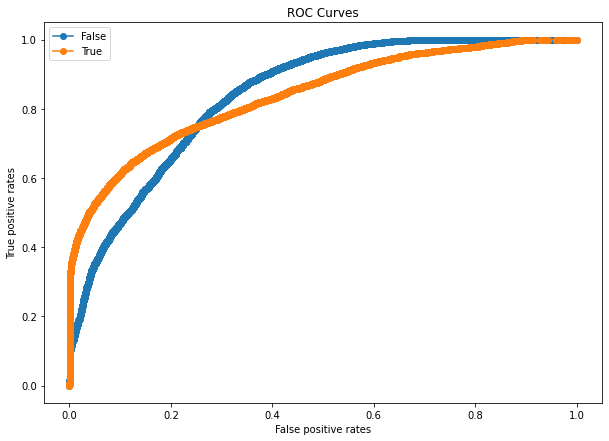

In [11]:
# ROC curves.
tools.ROCcurves(y_val, X_val, lr_pipeline)

#### Using SMOTE, synthetic oversample minority class

In [12]:
lr_pipeline1 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                            ce.OrdinalEncoder(mapping=cat_map),
                            SimpleImputer(),
                            SMOTE(random_state=42),
                            StandardScaler(),
                            LogisticRegression(n_jobs=-1,
                                               solver='lbfgs'))

tools.tryModel(lr_pipeline1, X_train, y_train, X_val, y_val)



Train score = 75.87391668518487 %
Validate score = 76.73101467772814 %




'Confusion Matrix'

,False,True
False,12465,3172
True,2662,6773


'Metrics'

,precision,recall,f1-score
False,0.824023,0.797148,0.810363
True,0.681046,0.717859,0.698968


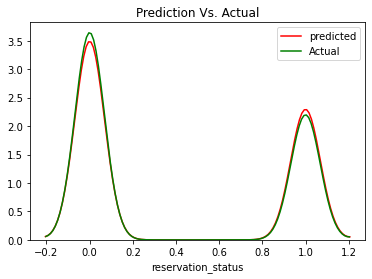

In [13]:
y_hat = lr_pipeline1.predict(X_val)
sns.distplot(y_hat, hist=False, color='red', label='predicted')
sns.distplot(y_val, hist=False, color='green', label='Actual')
plt.title('Prediction Vs. Actual')
plt.legend();

### Use random undersample on the majority class

In [14]:
lr_pipeline2 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                            ce.OrdinalEncoder(mapping=cat_map),
                            SimpleImputer(),
                            RandomUnderSampler(random_state=42),
                            StandardScaler(),
                            LogisticRegression(n_jobs=-1,
                                               solver='lbfgs'))

tools.tryModel(lr_pipeline2, X_train, y_train, X_val, y_val)



Train score = 75.93887283978052 %
Validate score = 76.7230376515635 %




'Confusion Matrix'

,False,True
False,12470,3167
True,2669,6766


'Metrics'

,precision,recall,f1-score
False,0.823700,0.797468,0.810372
True,0.681164,0.717117,0.698678


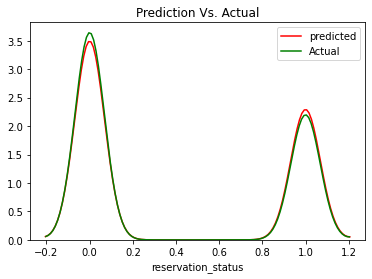

In [15]:
y_hat = lr_pipeline2.predict(X_val)
sns.distplot(y_hat, hist=False, color='red', label='predicted')
sns.distplot(y_val, hist=False, color='green', label='Actual')
plt.title('Prediction Vs. Actual')
plt.legend();

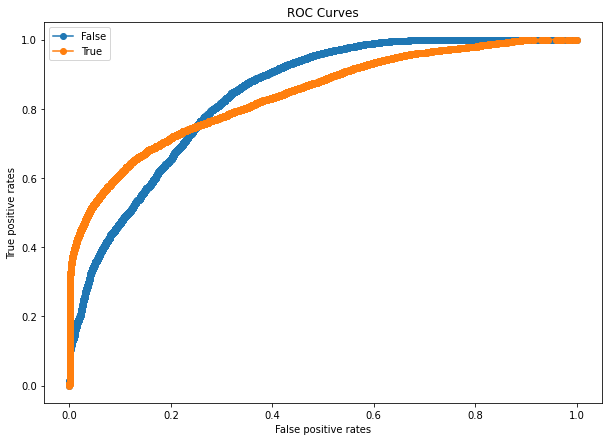

In [16]:
tools.ROCcurves(y_val, X_val, lr_pipeline2)

### Random Forest Classifier

The same protocol baseline, SMOTE, and undersampling

I have applied some hyperparameter tuning on basis of my previous investigations using grid searches, and inuition. Here I have manually adjusted the values to either side of what is here, finding what seems the best scores, including accuracy on training and validation sets -- to both maximize validation scores, while reducing overfitting on the training set. A threshold I am thinking in terms of here is that the variance between the accuracy scores of train and validation sets be less than 10% in variance.

#### Baseline random forest

In [17]:
model = RandomForestClassifier(random_state=42,
                              n_jobs=-1,
                              max_depth=35,
                              min_samples_leaf=1,
                              min_samples_split=2,
                              n_estimators=100)

rf_pipeline = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                             ce.OrdinalEncoder(mapping=cat_map),
                             SimpleImputer(),
                             model)

tools.tryModel(rf_pipeline, X_train, y_train, X_val, y_val)



Train score = 99.22223551734159 %
Validate score = 85.95245692405871 %




'Confusion Matrix'

,False,True
False,14291,1346
True,2176,7259


'Metrics'

,precision,recall,f1-score
False,0.867857,0.913922,0.890294
True,0.843579,0.769369,0.804767


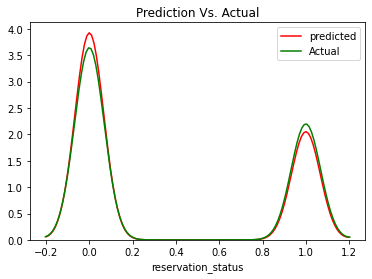

In [18]:
y_hat = rf_pipeline.predict(X_val)
sns.distplot(y_hat, hist=False, color='red', label='predicted')
sns.distplot(y_val, hist=False, color='green', label='Actual')
plt.title('Prediction Vs. Actual')
plt.legend()
plt.savefig('imbalance2.jpg')
plt.show()

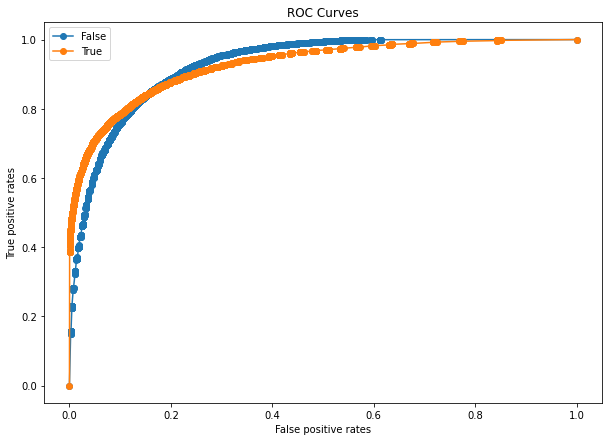

In [19]:
tools.ROCcurves(y_val, X_val, rf_pipeline)

#### Synthetic oversampling

In [20]:
rf_pipeline1 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                             ce.OrdinalEncoder(mapping=cat_map),
                             SimpleImputer(),
                             SMOTE(random_state=42),
                             model)

tools.tryModel(rf_pipeline1, X_train, y_train, X_val, y_val)



Train score = 98.84617356968258 %
Validate score = 85.92852584556478 %




'Confusion Matrix'

,False,True
False,14203,1434
True,2094,7341


'Metrics'

,precision,recall,f1-score
False,0.871510,0.908294,0.889522
True,0.836581,0.778060,0.806260


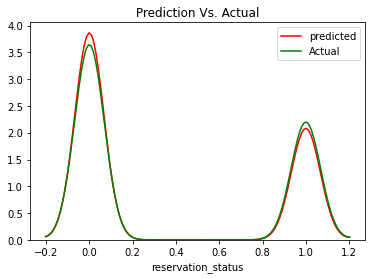

In [21]:
y_hat = rf_pipeline1.predict(X_val)
sns.distplot(y_hat, hist=False, color='red', label='predicted')
sns.distplot(y_val, hist=False, color='green', label='Actual')
plt.title('Prediction Vs. Actual')
plt.legend();

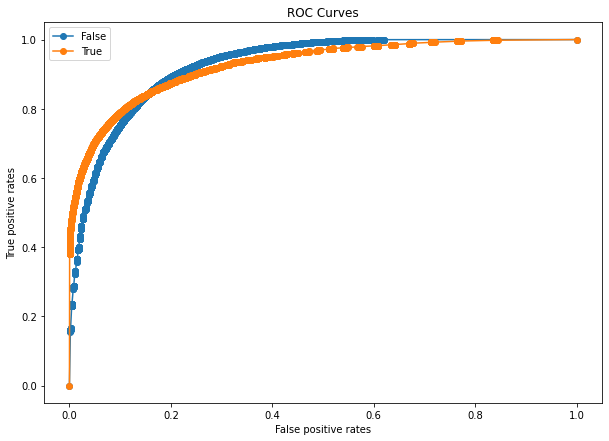

In [22]:
tools.ROCcurves(y_val, X_val, rf_pipeline1)

#### Random undersampling

In [23]:
rf_pipeline2 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                             ce.OrdinalEncoder(mapping=cat_map),
                             SimpleImputer(),
                             RandomUnderSampler(random_state=42),
                             model)

tools.tryModel(rf_pipeline2, X_train, y_train, X_val, y_val)



Train score = 95.7522093639425 %
Validate score = 84.6282705807275 %




'Confusion Matrix'

,False,True
False,13409,2228
True,1626,7809


'Metrics'

,precision,recall,f1-score
False,0.891852,0.857517,0.874348
True,0.778021,0.827663,0.802075


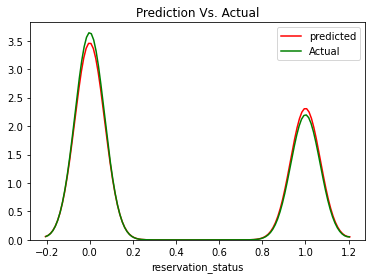

In [24]:
y_hat = rf_pipeline2.predict(X_val)
sns.distplot(y_hat, hist=False, color='red', label='predicted')
sns.distplot(y_val, hist=False, color='green', label='Actual')
plt.title('Prediction Vs. Actual')
plt.legend()
plt.savefig('balance.jpg')
plt.show()

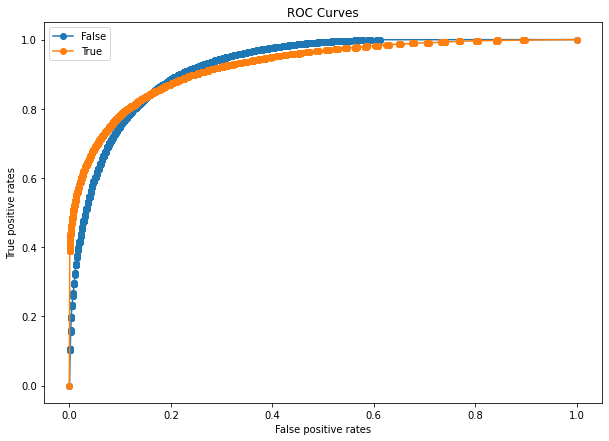

In [25]:
tools.ROCcurves(y_val, X_val, rf_pipeline2)

### Choosing which strategy

The random forest model performs better than the logisitic regression model overall. Looking at the recall scores, the strategy to use undersampling seems most effective. I also am tending to think (for now) that I trust better to random sample the majority cases rather than manufacturing data -- whether it be synthetic methods (using k-nearest neighbors to construct synthetic observations and outputs) or other bootstrapping methods such as resampling methods.

With subsampling I see about 1% decrease in the validation accuracy score, but significance in recall scores. The variance between accuracy scores of training and validation sets are also then < 10%. This I am thinking will lead to better the generalization of the model.

The next step here is to look at some of the interpretation of the chosen random forest model. 

#### Permutation Importances

First, wrangle and encode the training and validation sets to utilize tools outside of an estimator pipeline. We will though use a pipeline to streamline the process where we can, and promote consistency between proper application of transformations on both training and validation sets. 

In [26]:
# Do as much as we can in a pipeline
trans = make_pipeline(tools.wrangleData(max_cardinality=50),
                      ce.OrdinalEncoder(mapping=cat_map),
                      SimpleImputer())

trans.fit(X_train, y_train)
wrangler = trans.named_steps['wrangledata']
encoder = trans.named_steps['ordinalencoder']

# Apply to training set
X_train_enc = trans.transform(X_train)

# Apply random undersampling to training set, and make into pandas dataframe
# (Required for pdp)
X_train_enc, y_train_enc = RandomUnderSampler(random_state=42).fit_sample(X_train_enc, y_train)
X_train_enc = pd.DataFrame(X_train_enc, columns=wrangler.columns_)

# Apply transformations to validation set
X_val_enc = pd.DataFrame(trans.transform(X_val), columns=wrangler.columns_)

# refit the model
model.fit(X_train_enc, y_train_enc)

# Get a list of the categorical features, will be useful below
cat_features = tools.wrangleData().transform(X_train). \
                    select_dtypes(exclude='number').columns.tolist()

Permutation Importances



deposit_type                   0.091361
lead_time                      0.065388
total_of_special_requests      0.059493
market_segment                 0.041329
previous_cancellations         0.032307
customer_type                  0.029300
adr                            0.029036
room_type_changed              0.022727
nights_stay                    0.019217
arrival_date_week_number       0.017286
hotel                          0.016576
required_car_parking_spaces    0.015890
booking_changes                0.013377
adults                         0.006621
meal                           0.005688
is_repeated_guest              0.000582
days_in_waiting_list           0.000582
dtype: float64

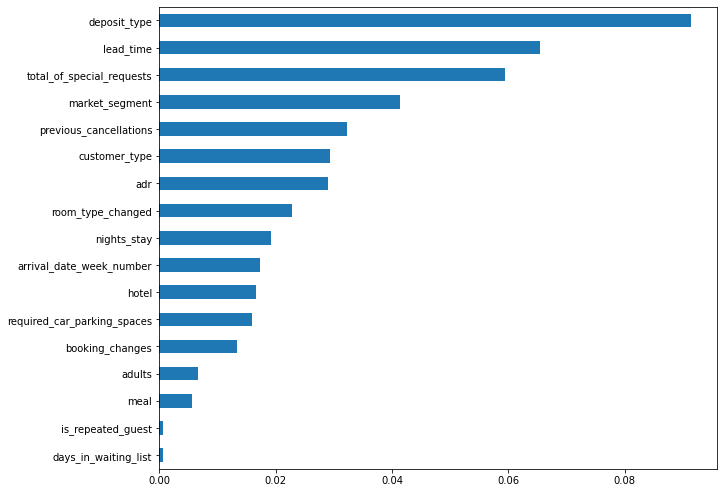

In [27]:
# Obtain the permutation importances
tools.permutationImports(model, X_val_enc, y_val)

#### PDP plots

Individual features, chosen from above importances

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


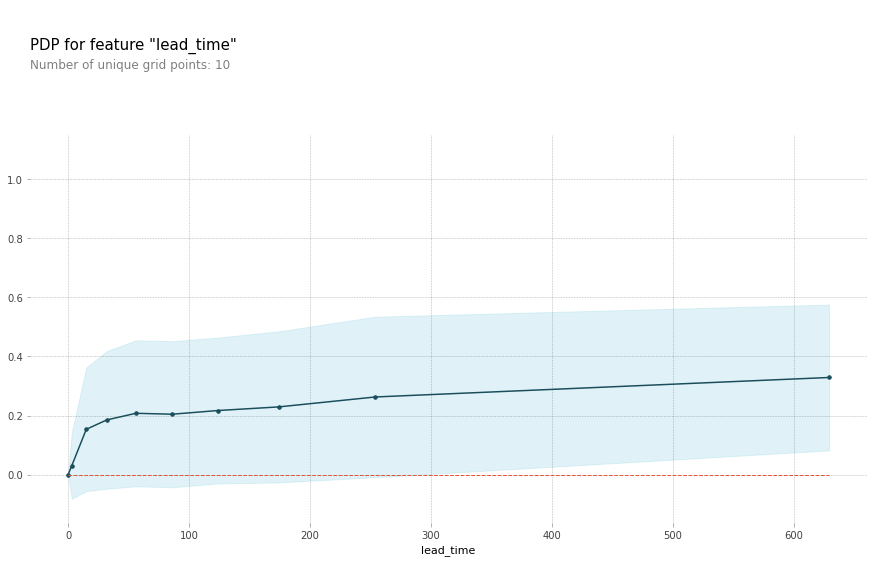

In [28]:
tools.plotFeature(model, X_val_enc, 'lead_time')

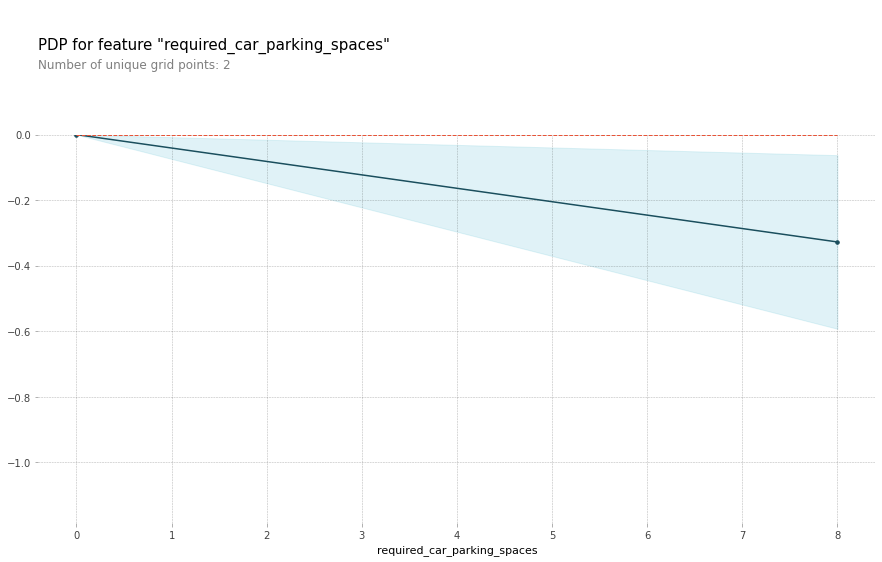

In [29]:
tools.plotFeature(model, X_val_enc, 'required_car_parking_spaces')

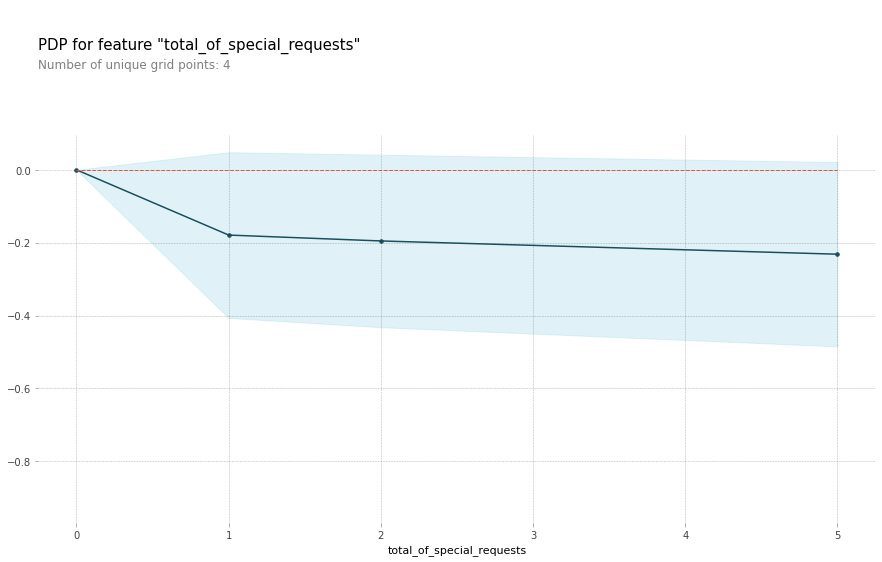

In [30]:
tools.plotFeature(model, X_val_enc, 'total_of_special_requests', cat_features, encoder.mapping)

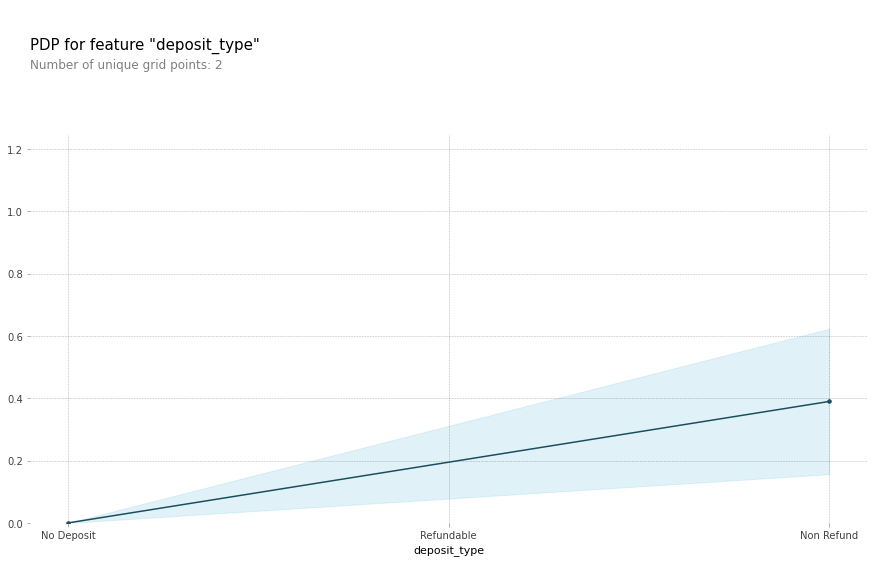

In [31]:
tools.plotFeature(model, X_val_enc, 'deposit_type', cat_features, encoder.mapping)

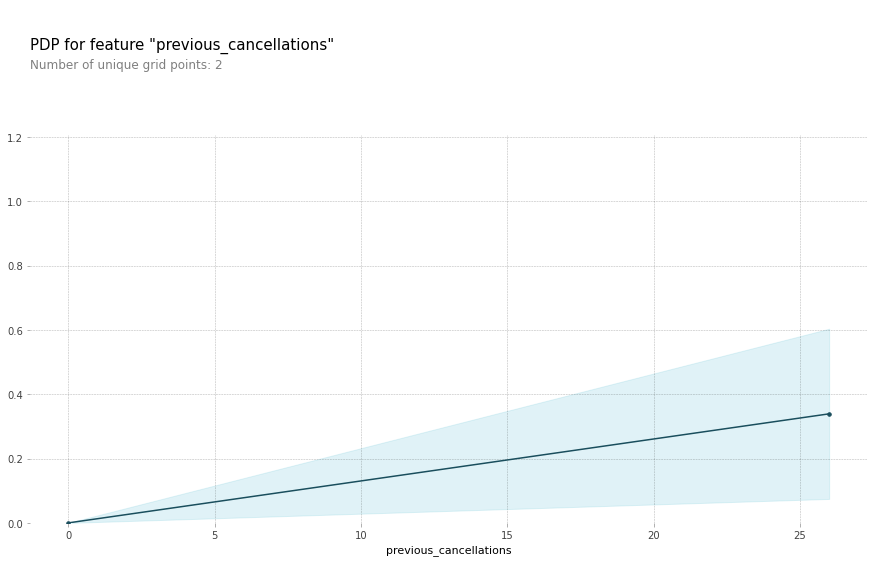

In [32]:
tools.plotFeature(model, X_val_enc, 'previous_cancellations')

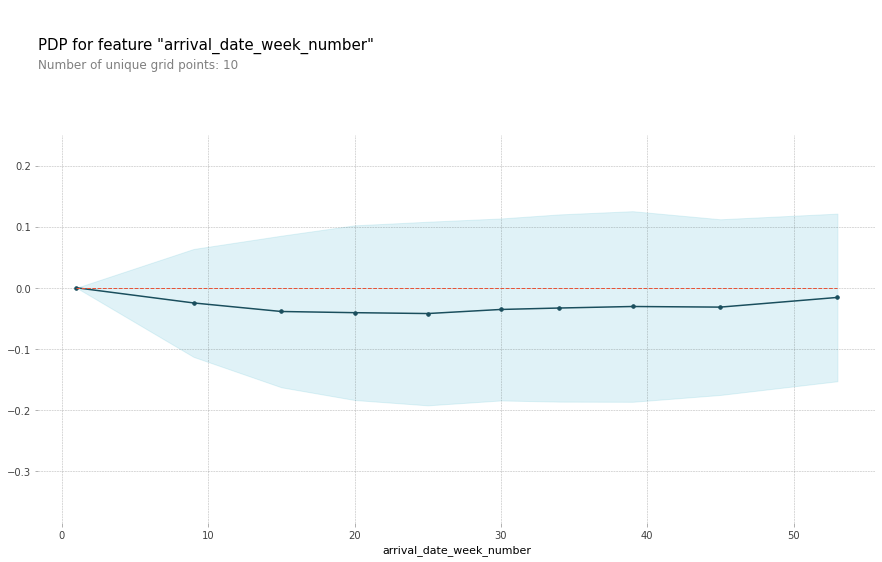

In [33]:
tools.plotFeature(model, X_val_enc, 'arrival_date_week_number')

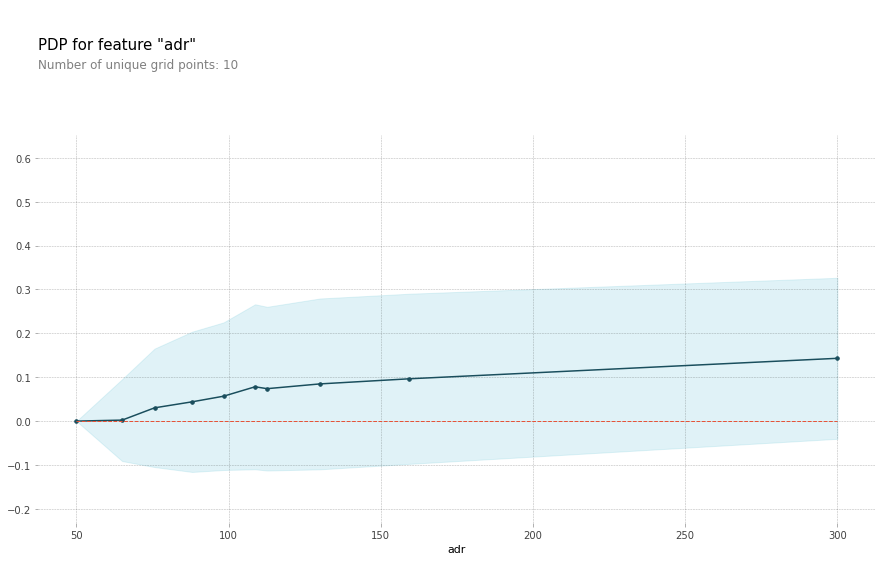

In [34]:
tools.plotFeature(model, X_val_enc, 'adr')

#### Interacting feature PDP plots

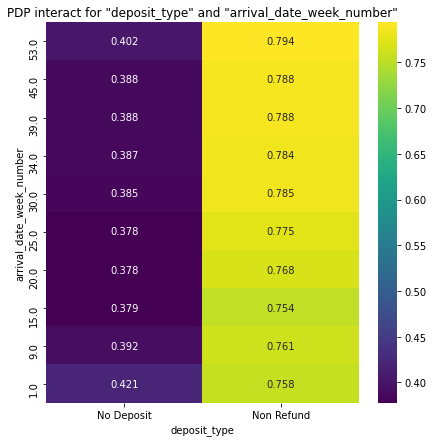

In [35]:
tools.plotFeatures(model, X_val_enc, ['deposit_type', 'arrival_date_week_number'], cat_features, encoder.mapping)

In [36]:
encoder.mapping

[{'col': 'meal', 'mapping': {'BB': 1, 'FB': 3, 'HB': 2, 'SC': 0}},
 {'col': 'hotel', 'mapping': {'City Hotel': 1, 'Resort Hotel': 2}},
 {'col': 'deposit_type',
  'mapping': {'No Deposit': 0, 'Non Refund': 2, 'Refundable': 1}},
 {'col': 'market_segment',
  'mapping': {'Aviation': 4,
   'Complementary': 0,
   'Corporate': 2,
   'Direct': 1,
   'Offline TA/TO': 5,
   'Online TA': 3,
   'Undefined': 1}},
 {'col': 'customer_type',
  'mapping': {'Contract': 3,
   'Group': 4,
   'Transient': 1,
   'Transient-Party': 2}}]

In [37]:
list(encoder.mapping[0]['mapping'].values())

[0, 1, 2, 3]

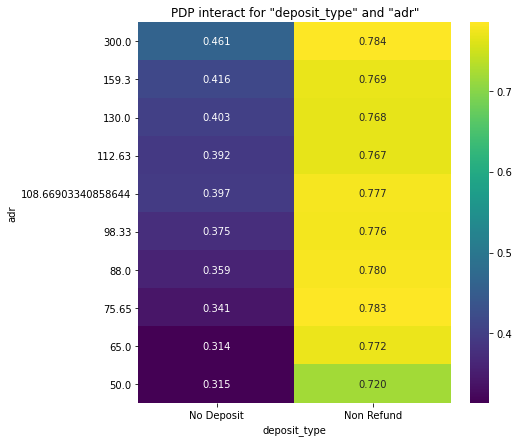

In [38]:
tools.plotFeatures(model, X_val_enc, ['deposit_type', 'adr'], cat_features, encoder.mapping)

#### Shapley plots of single observations

In [39]:
def shapPlot(model, input_data):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(input_data)

    shap.initjs()
    return shap.force_plot(base_value=explainer.expected_value[1],
                    shap_values=shap_values[1],
                    features=input_data,
                    link='logit')

We'll get some probabilities for each predicted class, and look at them sorted both ascending and descending to choose examples clearly canceled and check-out.


In [40]:
df = X_val_enc.copy()
y_pred = model.predict_proba(X_val_enc)
df['predicted_status'] = y_pred[:, 1]
df.sort_values(by='predicted_status', ascending=False).head(10)

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed,predicted_status
25071,1.0,274.0,29.0,2.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,2.0,62.000000,0.0,0.0,4.0,0.0,1.0
15012,1.0,34.0,50.0,1.0,1.0,5.0,0.0,1.0,0.0,2.0,0.0,1.0,90.000000,0.0,0.0,2.0,0.0,1.0
11886,1.0,467.0,30.0,2.0,1.0,5.0,0.0,0.0,0.0,2.0,0.0,1.0,90.000000,0.0,0.0,1.0,0.0,1.0
21238,1.0,444.0,49.0,1.0,1.0,5.0,0.0,1.0,0.0,2.0,39.0,1.0,75.000000,0.0,0.0,3.0,0.0,1.0
21239,1.0,56.0,24.0,2.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,120.000000,0.0,0.0,1.0,0.0,1.0
21244,1.0,153.0,25.0,1.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,110.000000,0.0,0.0,4.0,0.0,1.0
4453,2.0,201.0,45.0,2.0,1.0,-1.0,0.0,0.0,0.0,2.0,0.0,1.0,108.669033,0.0,0.0,3.0,0.0,1.0
4449,1.0,302.0,41.0,2.0,1.0,5.0,0.0,1.0,0.0,2.0,0.0,1.0,105.000000,0.0,0.0,3.0,0.0,1.0
17448,1.0,62.0,14.0,1.0,1.0,-1.0,0.0,0.0,0.0,2.0,0.0,1.0,135.000000,0.0,0.0,3.0,0.0,1.0
11895,1.0,335.0,38.0,2.0,1.0,-1.0,0.0,1.0,0.0,2.0,0.0,3.0,62.000000,0.0,0.0,2.0,0.0,1.0


In [41]:
df.sort_values(by='predicted_status').head(10)

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed,predicted_status
8657,2.0,152.0,14.0,2.0,1.0,-1.0,0.0,0.0,1.0,0.0,0.0,2.0,69.00,1.0,0.0,5.0,0.0,0.0
22441,1.0,4.0,13.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,107.00,0.0,2.0,2.0,0.0,0.0
18721,2.0,80.0,15.0,2.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,2.0,68.00,0.0,0.0,3.0,0.0,0.0
14316,1.0,100.0,21.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,136.00,0.0,1.0,4.0,0.0,0.0
5838,2.0,1.0,7.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,98.00,1.0,0.0,2.0,0.0,0.0
1662,2.0,24.0,19.0,2.0,2.0,-1.0,0.0,0.0,0.0,0.0,0.0,2.0,85.00,0.0,0.0,7.0,0.0,0.0
16512,1.0,346.0,38.0,2.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,115.00,0.0,1.0,2.0,0.0,0.0
24340,1.0,60.0,14.0,2.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,75.00,0.0,0.0,5.0,1.0,0.0
22433,1.0,140.0,47.0,2.0,1.0,-1.0,0.0,0.0,0.0,0.0,87.0,2.0,75.00,0.0,0.0,3.0,0.0,0.0
1655,1.0,219.0,36.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,76.67,0.0,0.0,3.0,0.0,0.0


Just select two examples of each result, and plot how different features result in each outcome.

In [42]:
row = X_val_enc.iloc[[25071]]
row

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed
25071,1.0,274.0,29.0,2.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,2.0,62.0,0.0,0.0,4.0,0.0


In [43]:
shapPlot(model, row)

In [46]:
row = X_val_enc.iloc[[9722]]
row

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed
9722,1.0,360.0,42.0,2.0,1.0,-1.0,0.0,1.0,0.0,2.0,0.0,3.0,62.0,0.0,0.0,2.0,0.0


In [47]:
shapPlot(model, row)

In [48]:
row = X_val_enc.iloc[[93]]
row

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed
93,1.0,63.0,30.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,114.3,1.0,2.0,2.0,0.0


In [49]:
shapPlot(model,row)

In [50]:
row = X_val_enc.iloc[[9575]]
row

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed
9575,1.0,49.0,27.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,116.7,1.0,1.0,3.0,0.0


In [51]:
shapPlot(model, row)

In [52]:
X_train_enc.head()

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed
0,1.0,12.0,2.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,67.58,0.0,0.0,4.0,0.0
1,1.0,150.0,22.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,126.00,0.0,0.0,4.0,0.0
2,1.0,206.0,13.0,2.0,1.0,-1.0,0.0,0.0,1.0,0.0,0.0,2.0,72.00,0.0,0.0,3.0,0.0
3,2.0,72.0,37.0,2.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,112.00,0.0,1.0,7.0,0.0
4,2.0,289.0,47.0,2.0,2.0,-1.0,0.0,0.0,0.0,0.0,0.0,2.0,57.00,0.0,0.0,3.0,0.0


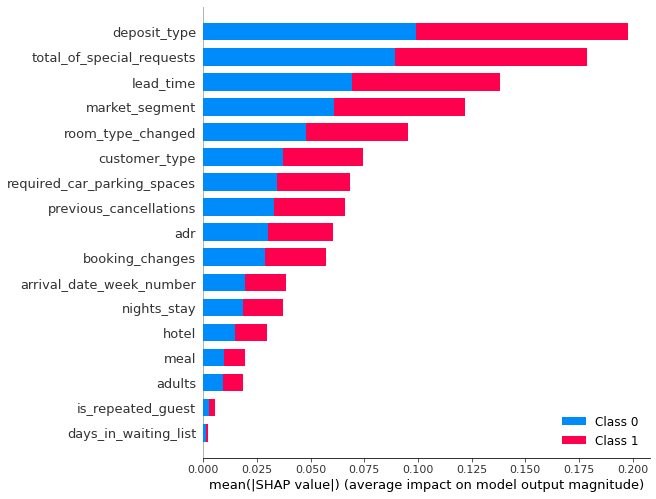

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(X_val_enc)
shap.summary_plot(shap_values, X_val_enc)

###Extra model

This is just a simple, quick regression model, to estimate a nightly rate based on season (week of year), number of adults, nights of stay, and meal service

In [53]:
price_features = ['arrival_date_week_number', 'hotel', 'adults', 'nights_stay']

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures

price = make_pipeline(tools.wrangleData(max_cardinality=50),
                      ce.OrdinalEncoder(mapping=cat_map),
                      tools.selectFeatures(price_features),
                      SimpleImputer(),
                      PolynomialFeatures(degree=2),
                      DecisionTreeRegressor()
                      )

y = X_train['adr']
price.fit(X_train, y)

Pipeline(memory=None,
         steps=[('wrangledata',
                 wrangleData(max_cardinality=50, remove_dates=True)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=['hotel', 'meal', 'market_segment',
                                      'deposit_type', 'customer_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'meal',
                                          'mapping': {'BB': 1, 'FB': 3, 'HB': 2,
                                                      'SC': 0}},
                                         {'col': 'hotel',
                                          'mappin...
                                    interaction_only=False, order='C')),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=None, max_fea

In [55]:
from sklearn.metrics import mean_absolute_error, r2_score

In [56]:
y_adr = X_val['adr']
y_pred = price.predict(X_val)
mae = mean_absolute_error(y_adr, y_pred)
r2 = r2_score(y_adr, y_pred)
print(f'MAE = {mae}\nR2 = {r2}')

MAE = 24.80352943218407
R2 = 0.31882022286698664


In [57]:
pd.Series(y_pred).describe()

count    25072.000000
mean       101.783010
std         35.456633
min          0.000000
25%         81.874375
50%        100.224581
75%        116.311921
max        315.000000
dtype: float64

In [58]:
y_pred.max()

315.0

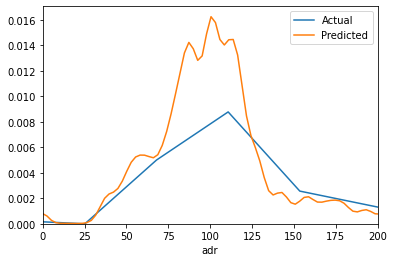

In [59]:
sns.distplot(y_adr, hist=False, label='Actual')
sns.distplot(y_pred, hist=False, label='Predicted')
plt.xlim(0, 200)
plt.legend()
plt.savefig('prices.jpg')
plt.show()

In [ ]:
from joblib import dump
dump(model, 'cancellation_model.joblib', compress=True)
dump(price_model, 'price_model.joblib', compress=True)

['price_model.joblib']

### Test data

In [63]:
y_predictions = rf_pipeline2.predict(X_test)

In [65]:
final_results = tools.class_metrics(y_test, y_predictions)
final_results[0]

,False,True
False,19190,3148
True,2382,11097


In [66]:
final_results[1]

,precision,recall,f1-score
False,0.889579,0.859074,0.874061
True,0.779010,0.823281,0.800534


In [69]:
final_score = rf_pipeline2.score(X_test, y_test)
print(f'Accuracy Score on the test set = {final_score * 100} %')

Accuracy Score on the test set = 84.56040427729849 %
